### We would like to answer some questions after exploring and analyzing the data:

#### Recommend a Driver's Lifetime Value (i.e., the value of a driver to Lyft over the entire projected lifetime of a driver).
#### What are the main factors that affect a driver's lifetime value?
#### What is the average projected lifetime of a driver? That is, once a driver is onboarded, how long do they typically continue driving with Lyft?
#### Do all drivers act alike? Are there specific segments of drivers that generate more value for Lyft than the average driver?
#### What actionable recommendations are there for the business?

In [1]:
# Import the required libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

In [3]:
# Read all datasets
driver_ids = pd.read_csv(r"C:\Users\Hemant Rajput\Downloads\Lyft dataset\datasets\driver_ids.csv")

ride_timestamps = pd.read_csv(r"C:\Users\Hemant Rajput\Downloads\Lyft dataset\datasets\ride_timestamps.csv")

ride_ids = pd.read_csv(r"C:\Users\Hemant Rajput\Downloads\Lyft dataset\datasets\ride_ids.csv")

In [4]:
# print sample of driver_ids data 
driver_ids.sample(2)

,driver_id,driver_onboard_date
213,39eedffe18d7ec6c53741f9d46c7ab51,2016-04-22 00:00:00
483,7dfa12ce1fc9cc58ec34fd66c75b106b,2016-05-13 00:00:00


In [5]:
# Some info about driver_ids data 

# Print shape (num. of rows, num. of columns) 
print('Shape of data: ', driver_ids.shape)
# Print unique of driver id
print('unique of driver id: ', len(driver_ids['driver_id'].unique()) )
# Print Minimum and Maximum value of driver onboard date 
print('Minimum date: ',driver_ids['driver_onboard_date'].min())
print('Maximum date: ',driver_ids['driver_onboard_date'].max())

Shape of data:  (937, 2)
unique of driver id:  937
Minimum date:  2016-03-28 00:00:00
Maximum date:  2016-05-15 00:00:00


In [6]:
# print sample of ride_timestamps data
ride_timestamps.sample(2)

,ride_id,event,timestamp
98171,1a2ec7aa167d995cb30ab34f16ddf207,accepted_at,2016-05-19 11:33:05
929413,f52c889bf2bd77efeb82a9d6bcdfeba1,picked_up_at,2016-05-02 12:05:13


In [7]:
# Some info about ride_timestamps data 

# Print shape (num. of rows, num. of columns) 
print('Shape of data: ', ride_timestamps.shape)
# Print unique count of ride id
print('unique of ride id: ', len(ride_timestamps['ride_id'].unique()))
# Print count of every value in column Event
ride_timestamps['event'].value_counts()

Shape of data:  (970405, 3)
unique of ride id:  194081


dropped_off_at    194081
arrived_at        194081
requested_at      194081
picked_up_at      194081
accepted_at       194081
Name: event, dtype: int64

In [8]:
# print sample of ride_ids data 
ride_ids.sample(2)

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time
167280,d967f5296732fa55266b5f1314e7447b,1abcd08ce13c45f62cbc8bf38c1adff6,1380,362,0
56965,46da643aa47256fef0822a2f288e115b,e3c390fa85148102fc940d75a8a92099,4543,476,0


In [9]:
# Some info about ride_ids data 

# Print shape (num. of rows, num. of columns) 
print('Shape of data: ', ride_ids.shape)
# Print count unique values of driver id
print('unique of driver id: ', len(ride_ids['driver_id'].unique()))
# Print count unique values of ride id
print('unique of ride id: ', len(ride_ids['ride_id'].unique()))
# Description of numeric columns (ride_distance, ride_duration, ride_prime_time)
ride_ids.describe()

Shape of data:  (193502, 5)
unique of driver id:  937
unique of ride id:  193502


,ride_distance,ride_duration,ride_prime_time
count,193502.000000,193502.000000,193502.000000
mean,6955.218266,858.966099,17.305893
std,8929.444606,571.375818,30.825800
min,-2.000000,2.000000,0.000000
25%,2459.000000,491.000000,0.000000
50%,4015.000000,727.000000,0.000000
75%,7193.000000,1069.000000,25.000000
max,724679.000000,28204.000000,500.000000


### Now Create features based on datasets

In [10]:
# constant variables used  to calc. total cost of ride (driver's lifetime value)
BASEFARE = 2.00
COSTPERMILE = 1.15
COSTPERMIN = 0.22
SERVICEFEE = 1.75
MINFARE = 5.00
MAXFARE = 400.00
# calc. total life time of ride (convert ride_distance from meters to miles, convert ride_duration from seconds to minutes)
ride_ids['ride_total_cost'] = ( (BASEFARE + (COSTPERMIN*(ride_ids['ride_duration']/60)) + (COSTPERMILE*(ride_ids['ride_distance']*0.000621))) * (1 + ride_ids['ride_prime_time']/100) ) + SERVICEFEE

# Apply lower and upper bound to ride cost (Minimum Fare, Maximum Fare )
ride_ids['ride_total_cost'] = np.where(ride_ids['ride_total_cost'] < MINFARE, MINFARE, ride_ids['ride_total_cost'])
ride_ids['ride_total_cost'] = np.where(ride_ids['ride_total_cost'] > MAXFARE, MAXFARE, ride_ids['ride_total_cost'])
# print first 3 rows in dataframe 
ride_ids.head(3)

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,ride_total_cost
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50,8.488488
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0,9.117306
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0,8.191174


### Creating features of ride

In [11]:
# Pivot the ride events 
ride_events = ride_timestamps.pivot(index = 'ride_id', columns = 'event', values = 'timestamp')
ride_events.head(3)

event,accepted_at,arrived_at,dropped_off_at,picked_up_at,requested_at
ride_id,,,,,
00003037a262d9ee40e61b5c0718f7f0,2016-06-13 09:39:51,2016-06-13 09:44:31,2016-06-13 10:03:05,2016-06-13 09:44:33,2016-06-13 09:39:19
00005eae40882760d675da5effb89ae3,2016-05-14 05:23:25,2016-05-14 05:26:17,2016-05-14 05:34:17,2016-05-14 05:26:18,2016-05-14 05:23:21
000061d42cf29f73b591041d9a1b2973,2016-05-16 15:43:14,2016-05-16 15:47:29,2016-05-16 15:54:18,2016-05-16 15:47:32,2016-05-16 15:43:09


In [12]:
# Merge ride_ids data with ride events on ride_id 
ride_data = pd.merge(ride_ids, ride_events, on='ride_id')
print('Shape of Ride data :', ride_data.shape)
ride_data.head(3)

Shape of Ride data : (184819, 11)


,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,ride_total_cost,accepted_at,arrived_at,dropped_off_at,picked_up_at,requested_at
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50,8.488488,2016-04-23 02:14:15,2016-04-23 02:16:36,2016-04-23 02:22:07,2016-04-23 02:16:40,2016-04-23 02:13:50
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0,9.117306,2016-03-29 19:00:52,2016-03-29 19:03:57,2016-03-29 19:17:30,2016-03-29 19:04:01,2016-03-29 19:00:49
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0,8.191174,2016-06-21 11:56:39,2016-06-21 12:01:32,2016-06-21 12:11:07,2016-06-21 12:01:35,2016-06-21 11:56:31


In [13]:
# Info about ride_data
ride_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184819 entries, 0 to 184818
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   driver_id        184819 non-null  object 
 1   ride_id          184819 non-null  object 
 2   ride_distance    184819 non-null  int64  
 3   ride_duration    184819 non-null  int64  
 4   ride_prime_time  184819 non-null  int64  
 5   ride_total_cost  184819 non-null  float64
 6   accepted_at      184819 non-null  object 
 7   arrived_at       184818 non-null  object 
 8   dropped_off_at   184819 non-null  object 
 9   picked_up_at     184819 non-null  object 
 10  requested_at     184819 non-null  object 
dtypes: float64(1), int64(3), object(7)
memory usage: 16.9+ MB


In [14]:
# convert ride distance from meters to kilometers
ride_data["ride_distance"] = ride_data["ride_distance"]/1000
# convert ride duration from seconds to minutes 
ride_data["ride_duration"] = ride_data["ride_duration"]/60

# Create some Features
# It is the time a driver takes to accept a ride once it is requested in minutes.
ride_data['ride_accept_response_time'] = (pd.to_datetime(ride_data['accepted_at']) - pd.to_datetime(ride_data['requested_at'])).astype('timedelta64[s]')/60
# It is the time a driver takes to reach the pickup location once a ride is accepted in minutes.
ride_data['ride_arrival_time'] = (pd.to_datetime(ride_data['arrived_at']) - pd.to_datetime(ride_data['accepted_at'])).astype('timedelta64[s]')/60
# It is the time a driver waits for the rider once the driver reaches the pickup location in minutes.
ride_data['ride_wait_time'] = (pd.to_datetime(ride_data['picked_up_at']) - pd.to_datetime(ride_data['arrived_at'])).astype('timedelta64[s]')/60
# divide ride distance to 3 categories (Short ride, medium ride, long ride) dependant on ride_distance column (KM)
ride_data["ride_length"] = np.where(ride_data["ride_distance"] > ride_data['ride_distance'].quantile(0.33), (np.where(ride_data["ride_distance"] < ride_data['ride_distance'].quantile(0.66), "med_ride", "long_ride")), "short_ride")
# divide ride time to 3 categories (Morning ride, evening ride, night ride) dependant on accepted_at column (time)
ride_data["ride_time"] = np.where(pd.to_datetime(ride_data['accepted_at']).dt.hour > 6, (np.where(pd.to_datetime(ride_data['accepted_at']).dt.hour <= 15, "morning_ride", (np.where(pd.to_datetime(ride_data['accepted_at']).dt.hour <= 21, "evening_ride", "night_ride")))), "night_ride")
# Convert accepted_at column to date
ride_data['ride_date'] = pd.to_datetime(ride_data['accepted_at']).dt.date
# Print first 3 rows in ride data
ride_data.head(3)

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,ride_total_cost,accepted_at,arrived_at,dropped_off_at,picked_up_at,requested_at,ride_accept_response_time,ride_arrival_time,ride_wait_time,ride_length,ride_time,ride_date
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1.811,5.450000,50,8.488488,2016-04-23 02:14:15,2016-04-23 02:16:36,2016-04-23 02:22:07,2016-04-23 02:16:40,2016-04-23 02:13:50,0.416667,2.350000,0.066667,short_ride,night_ride,2016-04-23
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3.362,13.483333,0,9.117306,2016-03-29 19:00:52,2016-03-29 19:03:57,2016-03-29 19:17:30,2016-03-29 19:04:01,2016-03-29 19:00:49,0.050000,3.083333,0.066667,med_ride,evening_ride,2016-03-29
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3.282,9.533333,0,8.191174,2016-06-21 11:56:39,2016-06-21 12:01:32,2016-06-21 12:11:07,2016-06-21 12:01:35,2016-06-21 11:56:31,0.133333,4.883333,0.050000,med_ride,morning_ride,2016-06-21


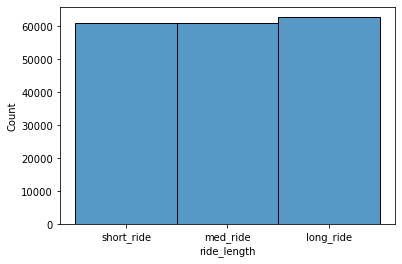

In [15]:
# histogram of ride length categories
sns.histplot(ride_data["ride_length"])
plt.show()

### Create Features of the Drivers

In [16]:
# calculate driver_perday_ridecount
driver_perday_ridecount = ride_data.pivot_table(index = 'driver_id', columns = 'ride_date', aggfunc='size').fillna(0)
driver_perday_ridecount.head(3)

ride_date,2016-03-28,2016-03-29,2016-03-30,2016-03-31,2016-04-01,2016-04-02,2016-04-03,2016-04-04,2016-04-05,2016-04-06,...,2016-06-17,2016-06-18,2016-06-19,2016-06-20,2016-06-21,2016-06-22,2016-06-23,2016-06-24,2016-06-25,2016-06-26
driver_id,,,,,,,,,,,,,,,,,,,,,
002be0ffdc997bd5c50703158b7c2491,0.0,6.0,0.0,8.0,7.0,5.0,0.0,0.0,7.0,0.0,...,1.0,3.0,0.0,2.0,9.0,3.0,5.0,0.0,0.0,0.0
007f0389f9c7b03ef97098422f902e62,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
011e5c5dfc5c2c92501b8b24d47509bc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
driver_info = pd.DataFrame()
# Calc. driver total ride count
driver_info['total_ride_count'] = ride_data.pivot_table(index=['driver_id'], aggfunc='size')
# Calc. driver total ride distance
driver_info['total_distance']  = ride_ids.groupby('driver_id')['ride_distance'].sum()
# Calc. driver total ride duration
driver_info['total_duration']  = ride_ids.groupby('driver_id')['ride_duration'].sum()
# Calc. driver lifetime value (total revenue)
driver_info['lifetime_value'] = ride_ids.groupby('driver_id')['ride_total_cost'].sum()
# Calc. mean driver count ride per day
driver_info['perday_ridecount_mean'] = driver_perday_ridecount.mean(axis=1)
# Calc. mean of ride accept responce time for every driver
driver_info['accept_response_time_mean'] = (ride_data.groupby(ride_data['driver_id']).aggregate({'ride_accept_response_time': 'mean'})).iloc[:,0]
# Calc. mean of ride arrival time for every driver
driver_info['arrival_time_mean'] = (ride_data.groupby(ride_data['driver_id']).aggregate({'ride_arrival_time': 'mean'})).iloc[:,0]
# Calc. mean of ride wait time for every driver
driver_info['wait_time_mean'] = (ride_data.groupby(ride_data['driver_id']).aggregate({'ride_wait_time': 'mean'})).iloc[:,0]
# count total no. of short/medium/long evening rides
driver_info = pd.merge(driver_info, ride_data.pivot_table(index = 'driver_id', columns = 'ride_length', aggfunc='size') ,on='driver_id')
# count total no. of day/night/night evening rides
driver_info = pd.merge(driver_info, ride_data.pivot_table(index = 'driver_id', columns = 'ride_time', aggfunc='size') ,on='driver_id')

# fill nan value with 0
driver_info = driver_info.fillna(0).reset_index()
driver_info.head(5)

,driver_id,total_ride_count,total_distance,total_duration,lifetime_value,perday_ridecount_mean,accept_response_time_mean,arrival_time_mean,wait_time_mean,long_ride,med_ride,short_ride,evening_ride,morning_ride,night_ride
0,002be0ffdc997bd5c50703158b7c2491,277,1740287,221238,3560.056648,3.043956,0.140132,2.883153,0.087184,79,103,95,103.0,85.0,89.0
1,007f0389f9c7b03ef97098422f902e62,31,117531,20497,321.434698,0.340659,0.197312,2.952688,0.081183,5,15,11,24.0,6.0,1.0
2,011e5c5dfc5c2c92501b8b24d47509bc,34,269653,29205,482.299206,0.373626,0.121569,3.720588,0.068137,11,11,12,24.0,8.0,2.0
3,0152a2f305e71d26cc964f8d4411add9,191,1471239,174521,2610.189071,2.098901,0.236649,3.908813,0.091885,99,51,41,17.0,67.0,107.0
4,01674381af7edd264113d4e6ed55ecda,375,3123644,357443,5379.644866,4.120879,0.208800,3.608133,0.136800,157,111,107,0.0,350.0,25.0


In [18]:
onboard_data = pd.merge(ride_data.groupby('driver_id').agg({'accepted_at': max}), driver_ids , on='driver_id')
# Calc. driver_duration the long of how driver continue driving with lyft par days
onboard_data['driver_duration'] = (pd.to_datetime(onboard_data['accepted_at']) - pd.to_datetime(onboard_data['driver_onboard_date'])).astype('timedelta64[D]')
onboard_data = onboard_data[['driver_id', 'driver_duration']]
onboard_data

,driver_id,driver_duration
0,002be0ffdc997bd5c50703158b7c2491,86.0
1,007f0389f9c7b03ef97098422f902e62,85.0
2,011e5c5dfc5c2c92501b8b24d47509bc,68.0
3,0152a2f305e71d26cc964f8d4411add9,64.0
4,01674381af7edd264113d4e6ed55ecda,56.0
...,...,...
832,ff419a3476e21e269e340b5f1f05414e,61.0
833,ff714a67ba8c6a108261cd81e3b77f3a,81.0
834,fff482c704d36a1afe8b8978d5486283,34.0
835,fffecccc49436c5389075b13209f0dfa,51.0


In [19]:
driver_info = pd.merge(driver_info, onboard_data, on= 'driver_id' , how='inner')
driver_info

,driver_id,total_ride_count,total_distance,total_duration,lifetime_value,perday_ridecount_mean,accept_response_time_mean,arrival_time_mean,wait_time_mean,long_ride,med_ride,short_ride,evening_ride,morning_ride,night_ride,driver_duration
0,002be0ffdc997bd5c50703158b7c2491,277,1740287,221238,3560.056648,3.043956,0.140132,2.883153,0.087184,79,103,95,103.0,85.0,89.0,86.0
1,007f0389f9c7b03ef97098422f902e62,31,117531,20497,321.434698,0.340659,0.197312,2.952688,0.081183,5,15,11,24.0,6.0,1.0,85.0
2,011e5c5dfc5c2c92501b8b24d47509bc,34,269653,29205,482.299206,0.373626,0.121569,3.720588,0.068137,11,11,12,24.0,8.0,2.0,68.0
3,0152a2f305e71d26cc964f8d4411add9,191,1471239,174521,2610.189071,2.098901,0.236649,3.908813,0.091885,99,51,41,17.0,67.0,107.0,64.0
4,01674381af7edd264113d4e6ed55ecda,375,3123644,357443,5379.644866,4.120879,0.208800,3.608133,0.136800,157,111,107,0.0,350.0,25.0,56.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832,ff419a3476e21e269e340b5f1f05414e,242,2002400,246308,3537.441127,2.659341,0.218939,4.651997,0.114738,98,56,88,56.0,161.0,25.0,61.0
833,ff714a67ba8c6a108261cd81e3b77f3a,485,2834765,442492,6285.948397,5.329670,0.177663,2.976426,0.048144,161,155,169,164.0,308.0,13.0,81.0
834,fff482c704d36a1afe8b8978d5486283,35,174394,27693,380.579655,0.384615,0.303333,3.835238,0.034762,11,7,17,1.0,34.0,0.0,34.0
835,fffecccc49436c5389075b13209f0dfa,406,2924913,353974,6050.600054,4.461538,0.176929,3.572619,0.191051,137,141,128,135.0,153.0,118.0,51.0


### Exploratory Data Analysis


In [20]:
# Get description of data 
driver_info.describe()

,total_ride_count,total_distance,total_duration,lifetime_value,perday_ridecount_mean,accept_response_time_mean,arrival_time_mean,wait_time_mean,long_ride,med_ride,short_ride,evening_ride,morning_ride,night_ride,driver_duration
count,837.000000,8.370000e+02,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000
mean,220.082437,1.528516e+06,189242.789725,2979.103812,2.418488,0.198516,4.417544,0.064720,74.874552,72.569892,72.637993,84.874552,85.178017,50.029869,55.075269
std,178.180347,1.259931e+06,154009.144305,2416.298144,1.958026,0.069286,1.406403,0.127561,60.894880,60.813653,62.422290,81.688592,92.089711,64.935745,21.721934
min,3.000000,9.895000e+03,1712.000000,25.687087,0.032967,0.084074,1.668056,-1.387415,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,44.000000,3.390140e+05,38363.000000,618.060833,0.483516,0.158730,3.458333,0.034524,18.000000,14.000000,14.000000,17.000000,15.000000,5.000000,42.000000
50%,224.000000,1.451389e+06,189906.000000,2958.450547,2.461538,0.184409,4.104848,0.059024,71.000000,72.000000,72.000000,60.000000,44.000000,22.000000,57.000000
75%,330.000000,2.311846e+06,288097.000000,4475.228280,3.626374,0.221540,5.042160,0.115833,114.000000,111.000000,112.000000,140.000000,139.000000,74.000000,73.000000
max,919.000000,6.628201e+06,779797.000000,12347.102999,10.098901,0.687500,12.045238,0.491954,335.000000,294.000000,313.000000,404.000000,515.000000,470.000000,90.000000


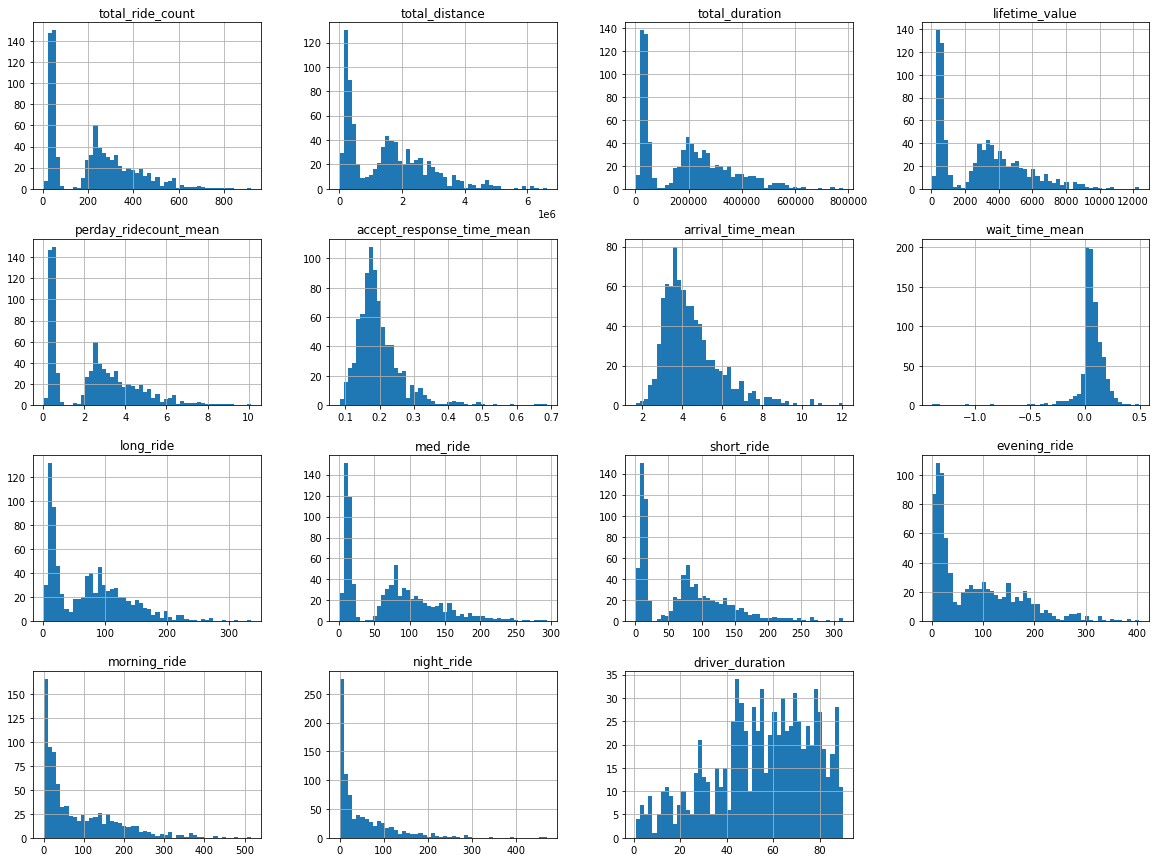

In [21]:
# Plot Histgrams of data 
driver_info.hist(bins=50, figsize=(20,15))
plt.show()

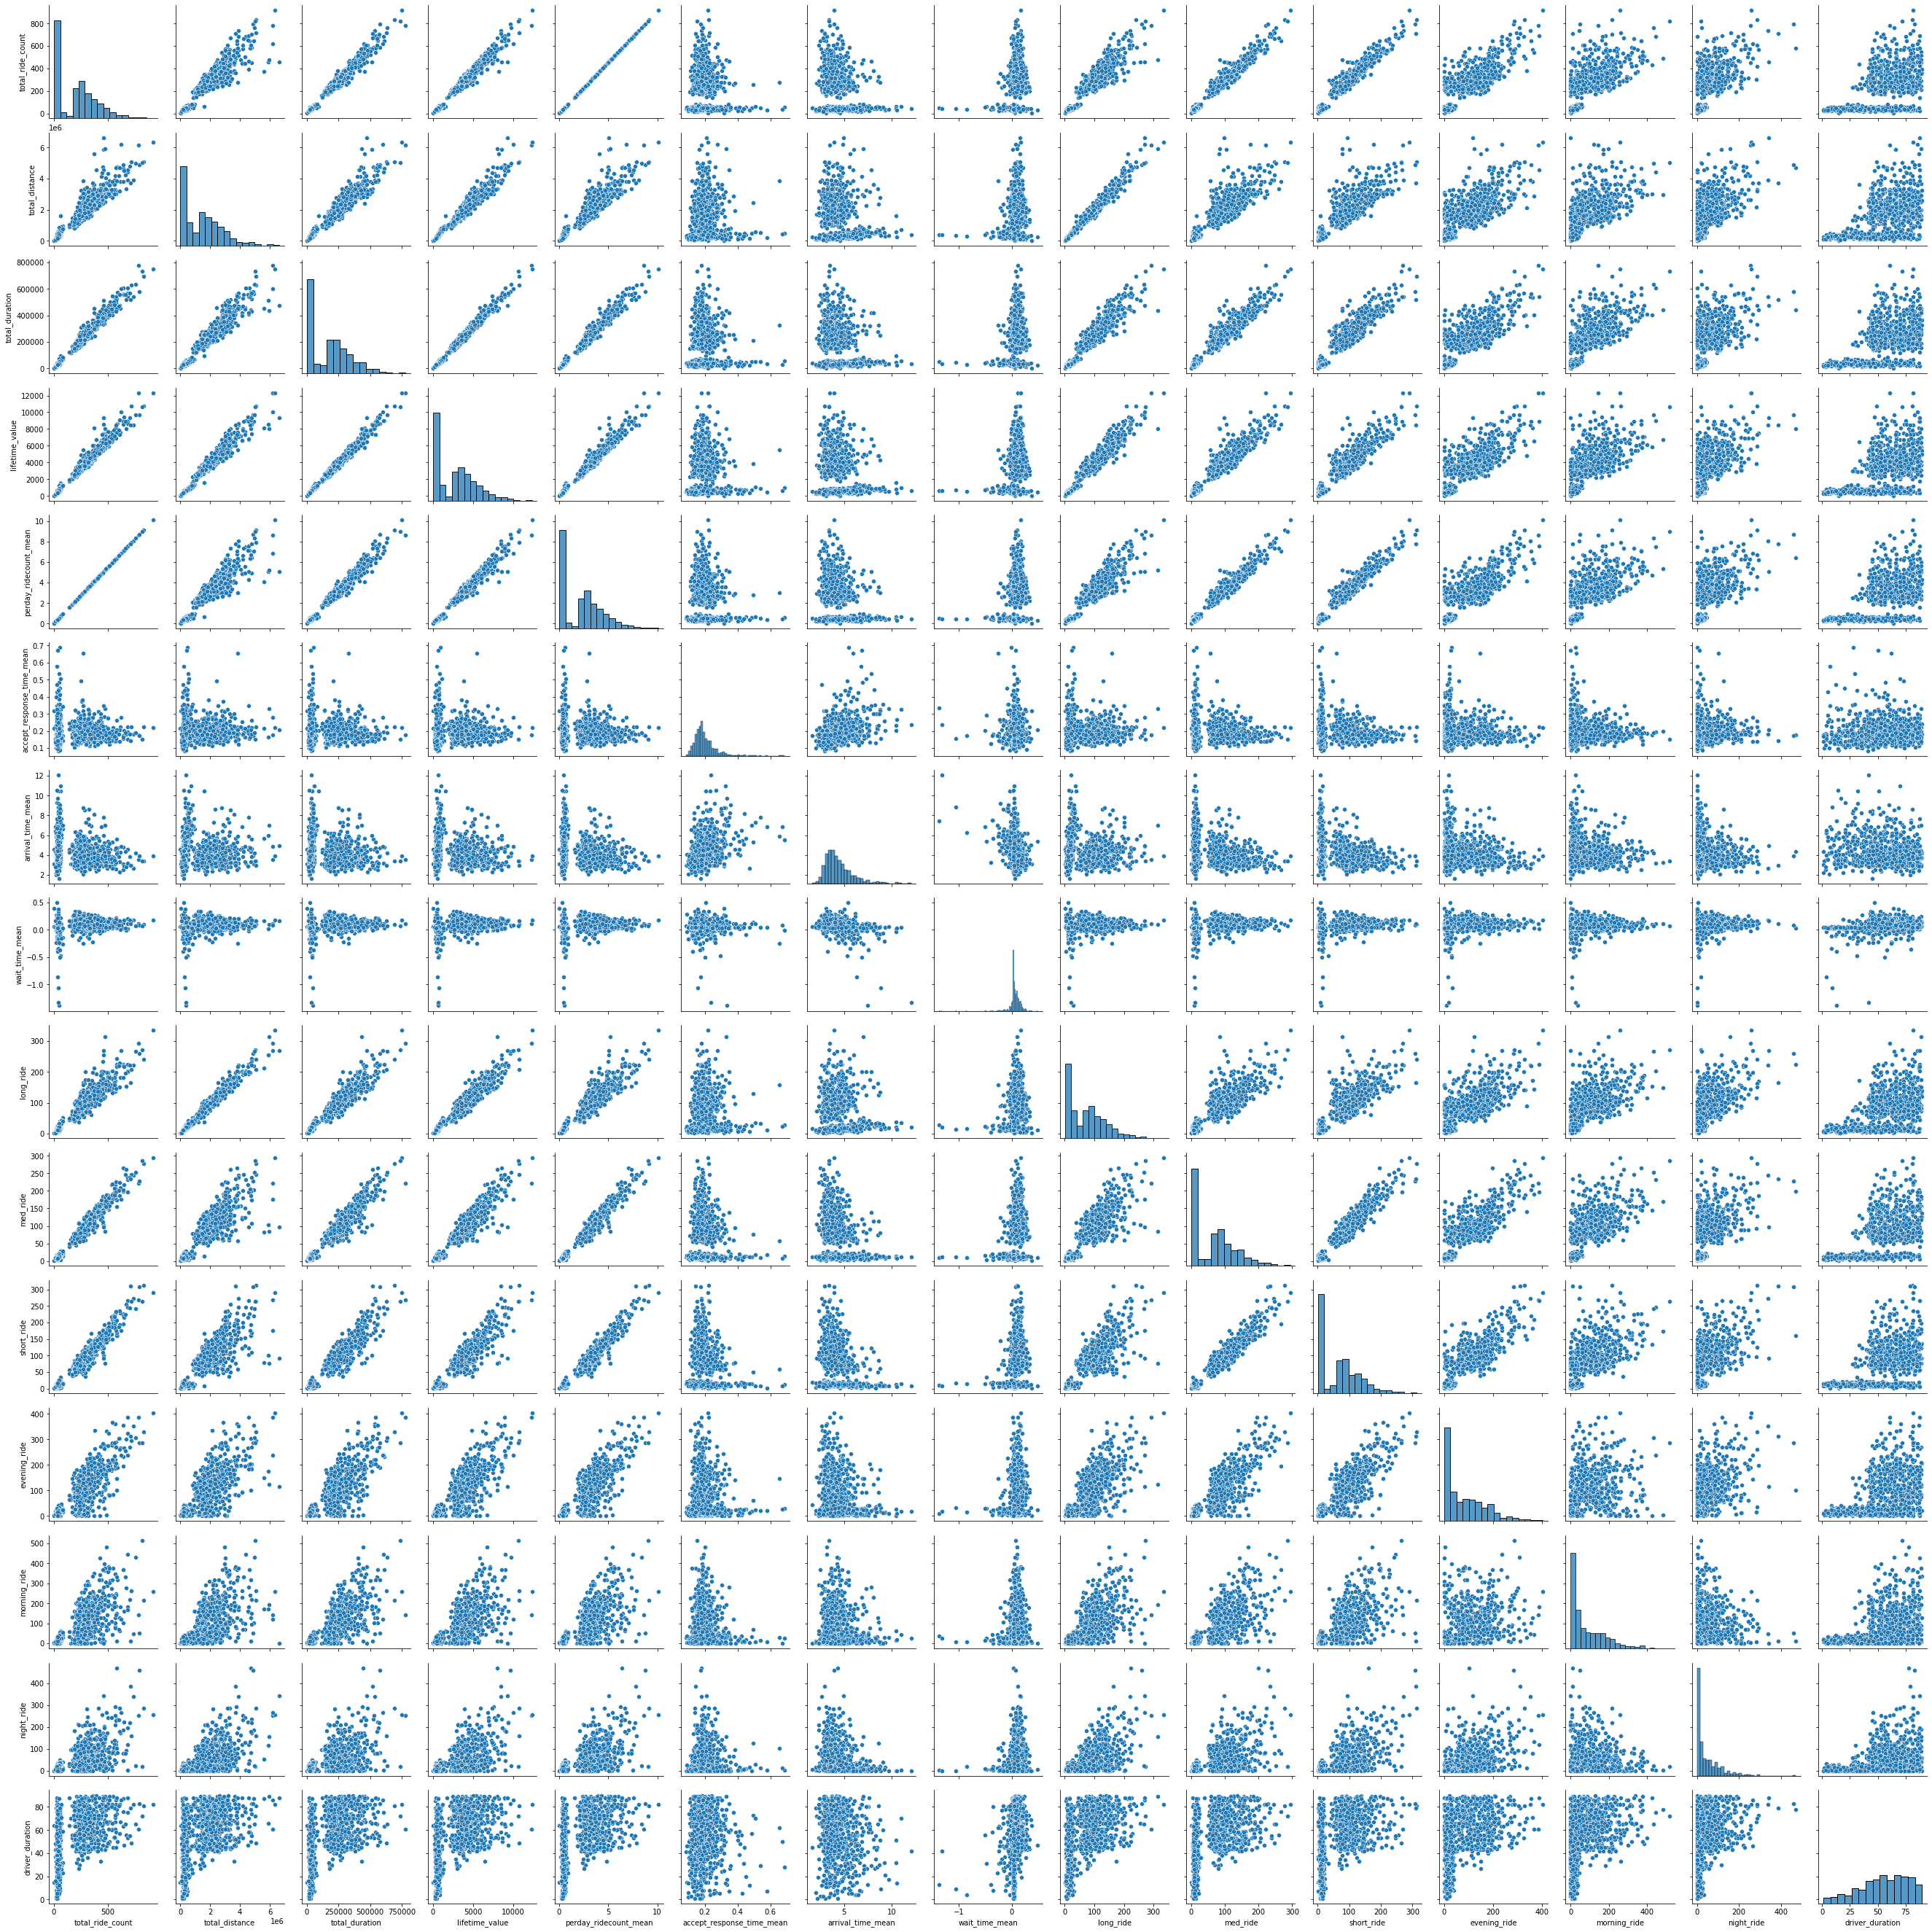

In [22]:
# scatter plots of data 
sns.pairplot(driver_info)

### Main Factors Affecting a Driver's Lifetime Value

<AxesSubplot:>

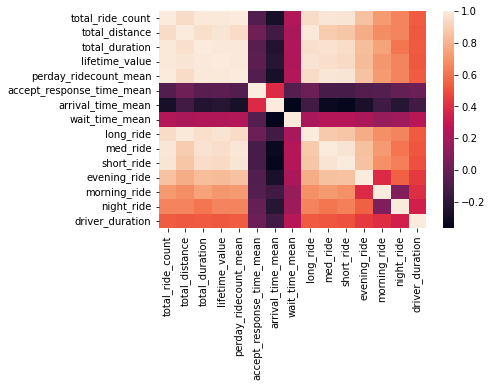

In [23]:
# plot a heatmap of correlations betweem features
sns.heatmap(driver_info.corr())

In [24]:
# get a correlation with lifetime_value as a DataFrame sorted in descending order
pd.DataFrame(driver_info.corr()['lifetime_value']).sort_values(by= 'lifetime_value' , ascending=False).iloc[1:]

,lifetime_value
total_duration,0.994194
perday_ridecount_mean,0.987069
total_ride_count,0.987069
total_distance,0.978453
long_ride,0.971439
med_ride,0.954142
short_ride,0.940301
evening_ride,0.833416
morning_ride,0.710687
night_ride,0.652164


### Average Projected Lifetime of a Driver

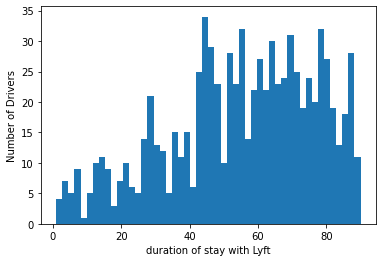

In [25]:
driver_info['driver_duration'].plot.hist(bins=50)
plt.xlabel('duration of stay with Lyft')
plt.ylabel('Number of Drivers')
plt.show()

In [26]:
driver_info['driver_duration'].describe()


count    837.000000
mean      55.075269
std       21.721934
min        1.000000
25%       42.000000
50%       57.000000
75%       73.000000
max       90.000000
Name: driver_duration, dtype: float64

### Do All Drivers Act Alike? 
#### To answer this question we will do a segmentation model using K-Means Clustering, to help us to know if all drivers act alike or not, and of there specific segments of drivers that generate more value for Lyft than the average driver or not.

In [28]:
pip install yellowbrick


Note: you may need to restart the kernel to use updated packages.


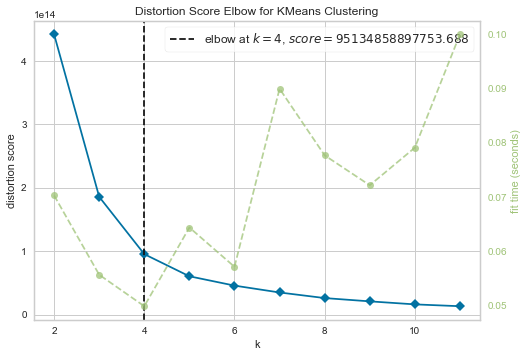

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [29]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

# Use the KElbowVisualizer to determine the optimal number of clusters
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2,12))
visualizer.fit(driver_info.drop(['driver_id'], axis=1))
visualizer.show()


In [30]:
# Fit a K-Means model with the optimal number of clusters
kmeans = KMeans(n_clusters=visualizer.elbow_value_, random_state=42)
kmeans.fit(driver_info.drop(['driver_id'], axis=1))

KMeans(n_clusters=4, random_state=42)

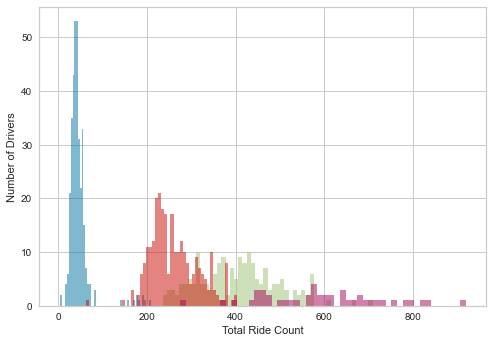

In [31]:
# Add the cluster labels to the dataframe
driver_info['cluster'] = kmeans.labels_

# Plot the distribution of total ride count by cluster
driver_info.groupby('cluster')['total_ride_count'].plot.hist(bins=50, alpha=0.5)
plt.xlabel('Total Ride Count')
plt.ylabel('Number of Drivers')
plt.show()


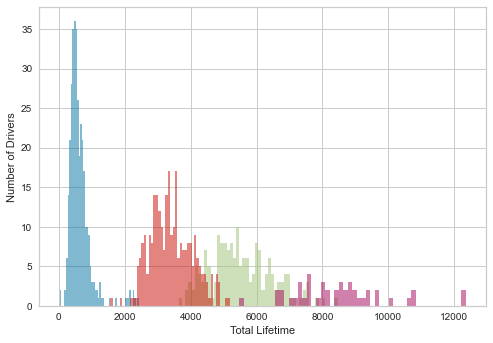

In [32]:
# Plot the distribution of total earnings by cluster
driver_info.groupby('cluster')['lifetime_value'].plot.hist(bins=50, alpha=0.5)
plt.xlabel('Total Lifetime')
plt.ylabel('Number of Drivers')
plt.show()

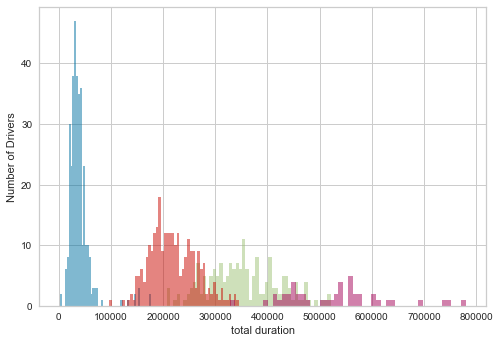

In [33]:
# Plot the distribution of total duration by cluster
driver_info.groupby('cluster')['total_duration'].plot.hist(bins=50, alpha=0.5)
plt.xlabel('total duration')
plt.ylabel('Number of Drivers')
plt.show()

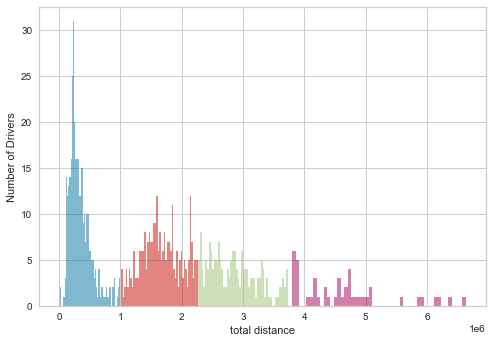

In [34]:
# Plot the distribution of total distance by cluster
driver_info.groupby('cluster')['total_distance'].plot.hist(bins=50, alpha=0.5)
plt.xlabel('total distance')
plt.ylabel('Number of Drivers')
plt.show()

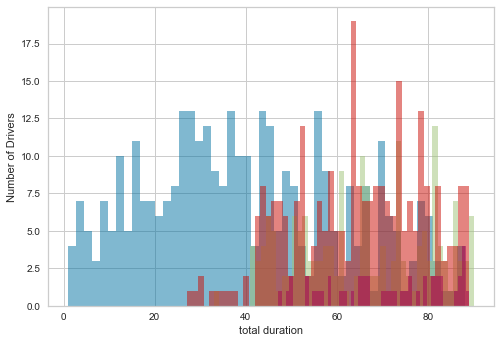

In [35]:
# Plot the distribution of driver's lifetime by cluster
driver_info.groupby('cluster')['driver_duration'].plot.hist(bins=50, alpha=0.5)
plt.xlabel('total duration')
plt.ylabel('Number of Drivers')
plt.show()

In [36]:
grouped_df = driver_info.groupby('cluster')['lifetime_value','med_ride', 'perday_ridecount_mean', 'total_ride_count', 'short_ride',
       'total_duration', 'total_distance', 'long_ride', 'evening_ride',
       'night_ride', 'morning_ride', 'driver_duration', 'wait_time_mean'].agg('mean')

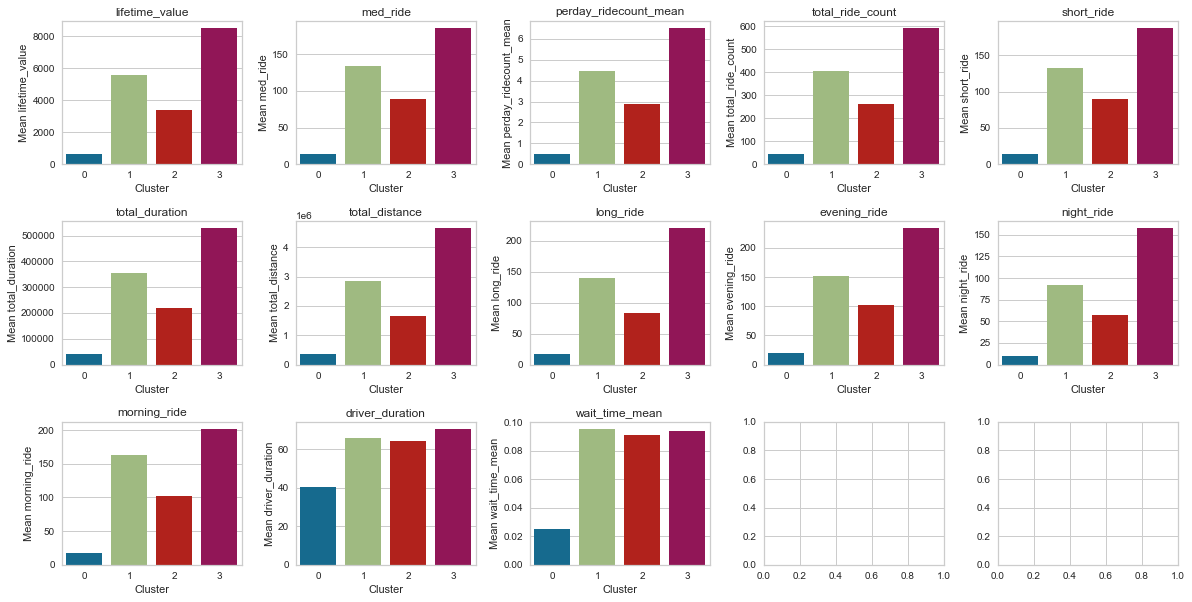

In [37]:
# create subplots for each column in the grouped dataframe
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20,10))
plt.subplots_adjust(wspace=0.3, hspace=0.4)

# loop through each column in the grouped DataFrame and plot it in a subplot
for i, column in enumerate(grouped_df.columns):
    sns.barplot(x=grouped_df.index, y=grouped_df[column], ax=axes[i//5, i%5])
    axes[i//5, i%5].set_title(column)
    axes[i//5, i%5].set_xlabel('Cluster')
    axes[i//5, i%5].set_ylabel('Mean ' + column)

plt.show()

### After seeing these plots we can define clusters as bad drivers, fair drivers, good drivers, and excellent drivers:

#### Cluster 0 is Bad drivers: This cluster has drivers with relatively low total lifetime value, low total ride count, and low total duration and distance. They may have issues with customer service, low demand for their services, or low fares.

#### Cluster 2 is Fair drivers: This cluster has drivers with moderate total lifetime value, ride count, duration, and distance. They may not have a high demand for their services, but they also do not have any major issues that impact their earnings.

#### Cluster 1 is Good drivers: This cluster has drivers with higher total lifetime value, higher ride count, and higher total duration and distance than the first two clusters. They may have a consistent demand for their services and a good reputation, leading to higher earnings.

#### Cluster 3 is Excellent drivers: This cluster has drivers with the highest total lifetime value, ride count, and total duration and distance. These drivers are likely the most in demand and have a good reputation for providing excellent service to their customers, leading to high earnings.

### Actionable recommendations 

#### Focus on retaining good and excellent drivers: The business should focus on retaining the drivers who belong to the good and excellent clusters as they bring in more revenue and have more frequent rides compared to other drivers.

#### Target improvement of fair drivers: The business should target to improve the performance of fair drivers, to convert them into good or excellent drivers.

#### Identify and address issues faced by bad drivers: The business should identify and address the issues faced by the bad drivers, such as low earnings, low ride frequency, and low ride duration, to improve their performance.

#### Personalized incentives and training: The business can offer personalized incentives and training to drivers based on their performance clusters to further improve their performance.

#### Use clustering results for dynamic pricing: The clustering results can be used for dynamic pricing, where prices can be adjusted based on the supply and demand of drivers in a particular area.

#### Monitor performance regularly: The business should regularly monitor the performance of drivers and reassess them based on the clustering results to ensure that they are being properly targeted with the appropriate incentives and support.